In [340]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os
import ast

## Скачивание

In [2]:
file_id = '1Fo4swaHNL7XW4xQ72It7Hf7L2UmtmbCg'
dataset_link = f'https://drive.google.com/uc?id={file_id}'
output_file = 'dataset.zip'

In [3]:
if not os.path.exists(output_file):
    gdown.download(dataset_link, output_file, quiet=False)
    print(f"Файл {output_file} скачан.")
else:
    print(f"Файл {output_file} уже существует.")

Файл dataset.zip уже существует.


In [4]:
df = pd.read_csv(output_file, compression='zip')

## Приведение типов

In [343]:
df.head(3)

,Game_ID,Rated,Variant,Speed,Created_At,Last_Move_At,Game_Status,Source,Winner,Opening_Name,...,Black_Inaccuracy,Black_Mistake,Black_Blunder,Black_ACPL,Clocks,Analysis,Total_Time_Init,Total_Time_Increment,Total_Time,Moves
0,PsevV6VH,True,standard,classical,2024-12-15T11:09:25.224000+00:00,2024-12-15T11:55:14.775000+00:00,resign,pool,white,English Opening: Symmetrical Variation,...,5,1,1,47,"[180003, 180003, 178499, 178019, 178339, 17757...","[{'eval': 14}, {'eval': 25}, {'eval': 26}, {'e...",1800,0,1800,Nf3 c5 c4 Nc6 Nc3 g6 e3 Bg7 d4 cxd4 exd4 d6 h3...
1,diLZa8sj,True,standard,classical,2024-10-28T13:54:16.605000+00:00,2024-10-28T14:32:21.403000+00:00,resign,pool,white,"French Defense: Winawer Variation, Advance Var...",...,4,0,1,31,"[180003, 180003, 179827, 179683, 178619, 17936...","[{'eval': 18}, {'eval': 28}, {'eval': 28}, {'e...",1800,0,1800,e4 e6 d4 d5 Nc3 Bb4 e5 Ne7 a3 Bxc3+ bxc3 b6 Bb...
2,O8TSZ7bq,True,standard,classical,2024-10-05T13:58:55.992000+00:00,2024-10-05T14:27:57.120000+00:00,resign,pool,black,London System,...,3,1,5,56,"[180003, 180003, 179707, 179035, 179051, 17678...","[{'eval': 17}, {'eval': 17}, {'eval': 11}, {'e...",1800,0,1800,d4 Nf6 Nf3 g6 Bf4 Bg7 e3 d6 Be2 O-O O-O Nbd7 h...


In [344]:
df.shape

(140792, 32)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140792 entries, 0 to 140791
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Game_ID               140792 non-null  object 
 1   Rated                 140792 non-null  bool   
 2   Variant               140792 non-null  object 
 3   Speed                 140792 non-null  object 
 4   Created_At            140792 non-null  object 
 5   Last_Move_At          140792 non-null  object 
 6   Game_Status           140792 non-null  object 
 7   Source                140792 non-null  object 
 8   Winner                127103 non-null  object 
 9   Opening_Name          139522 non-null  object 
 10  Opening_ECO           139522 non-null  object 
 11  Opening_PLY           139522 non-null  float64
 12  White_Player          140565 non-null  object 
 13  White_Title           46713 non-null   object 
 14  White_Rating          140565 non-null  float64
 15  

In [ ]:
df['Created_At'] = (
    pd.to_datetime(df['Created_At'], format='ISO8601')
    .dt.tz_localize(None)
    .dt.floor('s')
)

In [ ]:
df['Last_Move_At'] = (
    pd.to_datetime(df['Last_Move_At'], format='ISO8601')
    .dt.tz_localize(None)
    .dt.floor('s')
)

In [10]:
df['Clocks'] = df['Clocks'].apply(ast.literal_eval)

## Исследование данных

Посмотрим на пропуски в данных

In [345]:
df.isna().sum()[df.isna().sum() > 0]

Winner          13689
Opening_Name     1270
Opening_ECO      1270
Opening_PLY      1270
White_Player      227
White_Title     94079
White_Rating      227
Black_Player      311
Black_Title     94280
Black_Rating      311
dtype: int64

Анализ и удаление выбросов

1. Анализ и удаление выбросов в столбцах 'White_Mistake', 'Black_Mistake', 'White_Blunder', 'Black_Blunder'

In [346]:
# Выведем описательную статистику для этих столбцов.
df[['White_Mistake', 'Black_Mistake', 'White_Blunder', 'Black_Blunder']].describe()

,White_Mistake,Black_Mistake,White_Blunder,Black_Blunder
count,140792.000000,140792.000000,140792.000000,140792.000000
mean,1.177503,1.192397,1.697050,1.693271
std,1.307709,1.301948,1.929795,1.903644
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000
max,23.000000,21.000000,53.000000,53.000000


Вывод: Максимальные значения значительно превышают 75-й процентиль (Q3), это указывает на наличие выбросов.

Находим выбросы по столбцу 'White_Mistake'

In [347]:
# Вычисление Q1 и Q3
Q1_1 = df['White_Mistake'].quantile(0.25)
Q3_1 = df['White_Mistake'].quantile(0.75)

# Вычисление IQR
IQR_1 = Q3_1 - Q1_1

# 3. Определение границ для выбросов
lower_bound_1 = Q1_1 - 1.5 * IQR_1
upper_bound_1 = Q3_1 + 1.5 * IQR_1

# 4. Подсчет количества выбросов
outliers_1 = df[(df['White_Mistake'] < lower_bound_1) | (df['White_Mistake'] > upper_bound_1)]
number_of_outliers_1 = outliers_1.shape[0]

# Печать результата
print(f"Количество выбросов в столбце 'White_Mistake': {number_of_outliers_1}")

Количество выбросов в столбце 'White_Mistake': 1214


Находим выбросы по столбцу 'Black_Mistake'

In [348]:
# Вычисление Q1 и Q3
Q1_2 = df['Black_Mistake'].quantile(0.25)
Q3_2 = df['Black_Mistake'].quantile(0.75)

# Вычисление IQR
IQR_2 = Q3_2 - Q1_2

# 3. Определение границ для выбросов
lower_bound_2 = Q1_2 - 1.5 * IQR_2
upper_bound_2 = Q3_2 + 1.5 * IQR_2

# 4. Подсчет количества выбросов
outliers_2 = df[(df['Black_Mistake'] < lower_bound_2) | (df['Black_Mistake'] > upper_bound_2)]
number_of_outliers_2 = outliers_2.shape[0]

# Печать результата
print(f"Количество выбросов в столбце 'Black_Mistake': {number_of_outliers_2}")

Количество выбросов в столбце 'Black_Mistake': 1166


Находим выбросы по столбцу 'White_Blunder'

In [349]:
# Вычисление Q1 и Q3
Q1_3 = df['White_Blunder'].quantile(0.25)
Q3_3 = df['White_Blunder'].quantile(0.75)

# Вычисление IQR
IQR_3 = Q3_3 - Q1_3

# 3. Определение границ для выбросов
lower_bound_3 = Q1_3 - 1.5 * IQR_3
upper_bound_3 = Q3_3 + 1.5 * IQR_3

# 4. Подсчет количества выбросов
outliers_3 = df[(df['White_Blunder'] < lower_bound_3) | (df['White_Blunder'] > upper_bound_3)]
number_of_outliers_3 = outliers_3.shape[0]

# Печать результата
print(f"Количество выбросов в столбце 'White_Blunder': {number_of_outliers_3}")

Количество выбросов в столбце 'White_Blunder': 6787


Находим выбросы по столбцу 'Black_Blunder'

In [350]:
# Вычисление Q1 и Q3
Q1_4 = df['Black_Blunder'].quantile(0.25)
Q3_4 = df['Black_Blunder'].quantile(0.75)

# Вычисление IQR
IQR_4 = Q3_4 - Q1_4

# 3. Определение границ для выбросов
lower_bound_4 = Q1_4 - 1.5 * IQR_4
upper_bound_4 = Q3_4 + 1.5 * IQR_4

# 4. Подсчет количества выбросов
outliers_4 = df[(df['Black_Blunder'] < lower_bound_4) | (df['Black_Blunder'] > upper_bound_4)]
number_of_outliers_4 = outliers_4.shape[0]

# Печать результата
print(f"Количество выбросов в столбце 'Black_Blunder': {number_of_outliers_4}")

Количество выбросов в столбце 'Black_Blunder': 6519


Удалим выбросы из основного датафрейма.

In [351]:
# Объединяем все выбросы в один DataFrame
all_outliers = pd.concat([outliers_1, outliers_2, outliers_3, outliers_4]).drop_duplicates()

In [352]:
all_outliers.shape

(9970, 32)

In [353]:
# Удаляем выбросы из основного DataFrame
df = df[~df.index.isin(all_outliers.index)]

#### Параметр `Game_ID`

Game_ID - идентификатор партии - категориальный

Проверим на наличие в датасете дубликатов

In [354]:
df['Game_ID'].duplicated().sum()

6134

Удалим дубликаты

In [355]:
df.drop_duplicates(subset=['Game_ID'], inplace=True)

#### Параметр `Rated`

Rated - булевый признак, показывающий, является ли партия рейтинговой (True) или нет (False) - категориальный 

Посмотрим на распределение

In [356]:
df['Rated'].value_counts(dropna=False)

True     119001
False      5687
Name: Rated, dtype: int64

Отфильтруем нерейтинговые игры, чтобы избежать ошибок, связанных с некорректной игрой участников в партиях, не идущих на результат.

In [357]:
df = df[df['Rated'] == True].reset_index(drop=True)

#### Параметр `Variant`

Variant - вариант шахмат (например, классические, шахматы 960 и т. д.) - категориальный

In [358]:
df['Variant'].value_counts(dropna=False)

standard        118683
fromPosition       318
Name: Variant, dtype: int64

Отфильтруем значения fromPosition, чтобы не искажать данные играми, не начинающими с самого начала.

In [359]:
df = df[df['Variant'] != 'fromPosition'].reset_index(drop=True)

#### Параметр `Speed`

Speed - контроль времени партии (например, блиц, рапид, классика) - категориальный

In [360]:
df['Speed'].value_counts(dropna=False)

blitz          32561
rapid          28063
classical      26768
bullet         25445
ultraBullet     5846
Name: Speed, dtype: int64

Найдем распределение контроля времени по каждому элементу в процентах

In [361]:
# Группировка по 'Speed' и подсчет количества
speed_counts = df['Speed'].value_counts()

# Расчет процентов
total_speeds = speed_counts.sum()
speed_percentages = (speed_counts / total_speeds) * 100
speed_percentages = round(speed_percentages, 0)

# Создание DataFrame с количеством и процентами
top_speeds = pd.DataFrame({
    'Count': speed_counts,
    'Percentage': speed_percentages
}).reset_index()

# Переименование столбцов для удобства
top_speeds.columns = ['Speed', 'Count', 'Percentage']

In [362]:
top_speeds

,Speed,Count,Percentage
0,blitz,32561,27.0
1,rapid,28063,24.0
2,classical,26768,23.0
3,bullet,25445,21.0
4,ultraBullet,5846,5.0


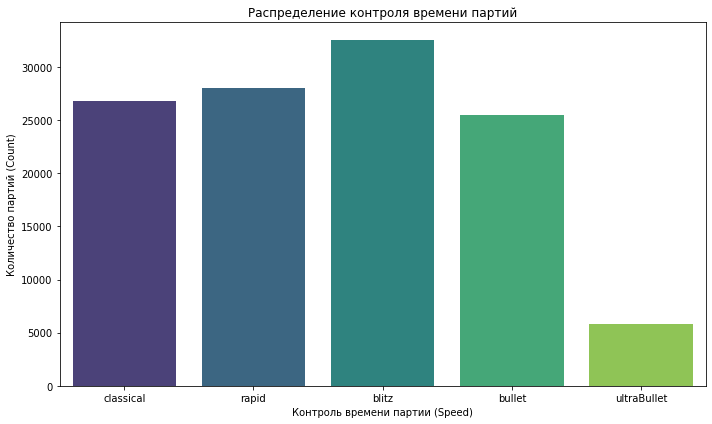

In [363]:
# Определяем порядок категорий
speed_order = ['classical', 'rapid', 'blitz', 'bullet', 'ultraBullet']

# Преобразуем столбец Speed в категориальный тип с заданным порядком
top_speeds['Speed'] = pd.Categorical(top_speeds['Speed'], categories=speed_order, ordered=True)

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
sns.barplot(data=top_speeds, x='Speed', y='Count', palette='viridis')

# Настройка графика
plt.title('Распределение контроля времени партий')
plt.xlabel('Контроль времени партии (Speed)')
plt.ylabel('Количество партий (Count)')
plt.xticks(rotation=0, ha='center')  # Убираем поворот и выравниваем по центру
plt.grid(False)  # Убираем сетку

# Показать график
plt.tight_layout()
plt.show()

classical - от 60 минут до нескольких часов.

rapid - от 10 до 60 минут.

blitz - от 3-х до 10 минут.

bullet - менее 3-х минут.

ultraBullet - менее 1-ой минуты.

#### Параметр `Source`

Source - источник партии (турнир, с другом, pool и т.д.) - категориальный

In [364]:
df['Source'].value_counts(dropna=False)

pool      73793
lobby     21490
arena     15510
friend     5861
swiss      1998
api          31
Name: Source, dtype: int64

Удалим игры через api, которые из-за нестандартного интерфейса для игрока могли повлиять на его уровень игры

In [365]:
df = df[df['Source'] != 'api'].reset_index(drop=True)

#### Параметр `Winner`

Winner - победитель партии (White, Black или None в случае ничьей) - категориальный

In [366]:
df['Winner'].value_counts(dropna=False, normalize=True)

white    0.475685
black    0.428438
NaN      0.095877
Name: Winner, dtype: float64

Заполним NA значения параметром draw

In [367]:
df['Winner'] = df['Winner'].fillna(value='draw')

Можно заметить, что в онлайн-шахматах доля побед значительно превышает долю ничьих, что не соответствует практическому опыту офлайн-шахмат.

#### Параметр `Game_Status`

Game_Status - статус завершения партии (ничья, мат, чит и т.д.) - категориальный

In [368]:
df['Game_Status'].value_counts(dropna=False)

resign       69230
mate         20392
outoftime    17657
draw          9953
timeout        769
stalemate      640
cheat           11
Name: Game_Status, dtype: int64

Удалим читерные партии из набора (cheat) и партии, где игроку засчитался проигрыш при отключении (timeout)

In [369]:
df = df[~df['Game_Status'].isin(['cheat', 'timeout'])].reset_index(drop=True)

#### Параметр `Opening_Name`

Opening_Name - название дебюта, который был сыгран - категориальный

In [370]:
df['Opening_Name'].value_counts(dropna=False)

Indian Defense                                                 1611
Sicilian Defense: Closed                                       1349
King's Indian Attack                                           1078
Zukertort Opening                                              1055
Sicilian Defense: Najdorf Variation                             949
                                                               ... 
Ruy Lopez: Closed, Smyslov-Breyer-Zaitsev Hybrid                  1
Sicilian Defense: Najdorf Variation, Scheveningen Variation       1
Old Indian Defense: Duz-Khotimirsky Variation                     1
Owen Defense: Naselwaus Gambit                                    1
Ponziani Opening: Ponziani Countergambit                          1
Name: Opening_Name, Length: 2276, dtype: int64

In [371]:
# TODO:что дальше?

#### Параметр `Opening_ECO`

Opening_ECO - код дебюта по системе ECO (Encyclopaedia of Chess Openings) - категориальный

In [372]:
df['Opening_ECO'].value_counts(dropna=False)

A00    4996
A04    3338
A45    3148
A05    2680
A40    2629
       ... 
E96       1
E89       1
E03       1
D98       1
E31       1
Name: Opening_ECO, Length: 486, dtype: int64

Найдем самые популярные дебюты и их процент в общей доле.

In [373]:
# Подсчет количества дебютов
opening_counts = df['Opening_ECO'].value_counts()

# Расчет процентов
total_openings = opening_counts.sum()
opening_percentages = (opening_counts / total_openings) * 100
opening_percentages = round(opening_percentages, 0)

# Создание DataFrame с количеством и процентами
top_openings = pd.DataFrame({
    'Count': opening_counts,
    'Percentage': opening_percentages
})

In [374]:
top_openings.head(3)

,Count,Percentage
A00,4996,4.0
A04,3338,3.0
A45,3148,3.0


Наиболее часто встречающиеся дебюты:

A00 (4 %) - "неопределенные дебюты".

A04 (3%) - дебют известный как "Скандинавская защита", начинается с хода пешки на королевском фланге и стремится быстро развивать фигуры, чтобы контролировать центр. Этот дебют обычно выбирают игроки, которые хотят атаковать и не боятся рискованных позиций.

A45 (3%) - дебют, который называется "Защита Оуэна", начинается с хода пешкой на королевском фланге, но сосредоточен на более медленном и стратегическом раскрытии фигур. Игроки, использующие этот дебют, часто стремятся к созданию сложной позиции и могут играть на противостоянии сопернику, ожидая, когда тот сделает ошибку.

#### Параметр `Opening_PLY`

Opening_PLY - количество полуходов до выхода из дебютной стадии - числовой

In [375]:
# TODO: логика?

#### Параметр `Created_At`

Created_At - время создания партии - категориальный

In [ ]:
# Создаем дополнительное поле - год игры
df['Created_Year'] = df['Created_At'].dt.to_period('Y')

year_counts = df.groupby('Created_Year').size()
year_counts

Удалим данные с 2014 по 2019 годы из-за малого числа наблюдений.

In [ ]:
df = df[~df['Created_Year'].astype(
    str).isin(['2014', '2015', '2016', '2017', '2018', '2019'])].reset_index(drop=True)

Теперь посмотрим на распределение

In [ ]:
plt.figure(figsize=(14, 4))
sns.barplot(x=year_counts.index.astype(str),
            y=year_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Год")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Created_At (год)")
plt.show()

Посмотрим на распределение игр по месяцам

In [ ]:
df['Created_Month'] = df['Created_At'].dt.month

month_counts = df.groupby('Created_Month').size()

plt.figure(figsize=(14, 5))
sns.barplot(x=month_counts.index.astype(str),
            y=month_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Месяц")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Created_At (месяц)")
plt.show()

Чаще всего играют в январе и декабре. Можно выделить спад в весенне-летний период

Узнаем в какой день недели чаще всего играют в шахматы

In [ ]:
df["weekday"] = df["Created_At"].dt.day_name()
ordered_days = ["Monday", "Tuesday", "Wednesday",
                "Thursday", "Friday", "Saturday", "Sunday"]

day_counts = df["weekday"].value_counts().reindex(ordered_days)


plt.figure(figsize=(14, 5))
sns.barplot(x=day_counts.index, y=day_counts.values,  color='blue')
plt.title("Распределение шахматных партий по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество партий")
plt.xticks(rotation=45)
plt.show()

По пятницам и субботам в шахматы играют чаще всего

Узнаем в какой время суток чаще всего играют в шахматы

In [ ]:
df["Hour"] = df["Created_At"].dt.hour
df["Hour"].value_counts().sort_index().plot(
    kind="bar", figsize=(14, 5), color='blue')
plt.title("Распределение партий по часам суток")
plt.xlabel("Час")
plt.ylabel("Количество партий")
plt.xticks(rotation=0)
plt.show()

Чаще всего люди играют в вечернее время (с 17 до 20 UTC)

#### Параметр `Last_Move_At`

Last_Move_At - время последнего хода в партии - категориальный

In [ ]:
# Создаем дополнительное поле - год игры
df['Last_Move_Year'] = df['Last_Move_At'].dt.to_period('Y')

last_move_year_counts = df.groupby('Last_Move_Year').size()
last_move_year_counts

In [ ]:
plt.figure(figsize=(14, 4))
sns.barplot(x=last_move_year_counts.index.astype(str),
            y=last_move_year_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Год")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Last_Move_At (год)")
plt.show()

In [ ]:
df['Last_Move_Month'] = df['Last_Move_At'].dt.month

last_move_month_counts = df.groupby('Last_Move_Month').size()

plt.figure(figsize=(14, 5))
sns.barplot(x=last_move_month_counts.index.astype(str),
            y=last_move_month_counts.values, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Месяц")
plt.ylabel("Количество записей")
plt.title("Распределение записей по Last_Move_At (месяц)")
plt.show()

In [ ]:
df["Last_Move_Hour"] = df["Last_Move_At"].dt.hour
df["Last_Move_Hour"].value_counts().sort_index().plot(
    kind="bar", figsize=(14, 5), color='blue')
plt.title("Распределение партий по часам суток")
plt.xlabel("Час")
plt.ylabel("Количество партий")
plt.xticks(rotation=0)
plt.show()

Данный параметр имеет то же распределение, что и `Created_At`

#### Параметр `White_Player`

White_Player - идентификатор игрока, игравшего белыми - категориальный

In [266]:
# TODO: что с этим полем?

#### Параметр `Black_Player`

Black_Player - идентификатор игрока, игравшего черными - категориальный

In [267]:
# TODO: что с этим полем?

#### Параметр `White_Title` и `Black_Title`

White_Title - шахматный титул игрока, игравшего белыми (например, GM, IM, FM) - категориальный

In [268]:
df['White_Title'].value_counts(dropna=False)

NaN    80310
GM     14420
FM      9301
IM      9270
CM      2429
NM      2038
LM        46
WFM       21
WIM       14
WCM       12
BOT       10
WGM        1
Name: White_Title, dtype: int64

In [269]:
df['Black_Title'].value_counts(dropna=False)

NaN    80364
GM     14308
FM      9333
IM      9277
CM      2383
NM      2095
LM        45
WFM       34
WIM       13
WCM        9
BOT        7
WGM        4
Name: Black_Title, dtype: int64

Заполним пропуски значением NT - No Title

In [270]:
df['White_Title'] = df['White_Title'].fillna('NT')
df['Black_Title'] = df['Black_Title'].fillna('NT')

#### Параметр `White_Rating`

White_Rating - рейтинг белого игрока - числовой

In [271]:
# TODO: что с этим полем?

#### Параметр `Black_Rating`

Black_Rating - рейтинг черного игрока - числовой

In [272]:
# TODO: что с этим полем?

#### Параметр `White_Inaccuracy`

White_Inaccuracy - количество неточностей, допущенных белым игроком - числовой

In [273]:
# TODO: что с этим полем?

#### Параметр `Black_Inaccuracy`

Black_Inaccuracy - количество неточностей, допущенных черным игроком - числовой

In [274]:
# TODO: что с этим полем?

#### Параметр `White_Mistake`

White_Mistake - количество ошибок, допущенных белым игроком - числовой

In [377]:
white_mistake_count = df['White_Mistake'].value_counts()

In [378]:
white_mistake_count

0     47239
1     35424
2     20372
3      9651
4      3773
5      1356
6        37
7        14
8         4
10        1
9         1
Name: White_Mistake, dtype: int64

#### Параметр `Black_Mistake`

Black_Mistake - количество ошибок, допущенных черным игроком - числовой

In [379]:
black_mistake_count = df['Black_Mistake'].value_counts()

In [380]:
black_mistake_count

0    45851
1    36526
2    20778
3     9527
4     3792
5     1329
6       45
7       14
8        7
9        3
Name: Black_Mistake, dtype: int64

#### Параметр `White_Blunder`

White_Blunder - количество грубых ошибок (зевков), допущенных белым игроком - числовой

In [381]:
white_blunder_count = df['White_Blunder'].value_counts()

In [382]:
white_blunder_count

0     38340
1     34059
2     22271
3     12823
4      6715
5      3348
6       138
7        85
8        37
9        32
11        9
10        9
12        3
23        1
14        1
13        1
Name: White_Blunder, dtype: int64

#### Параметр `Black_Blunder`

Black_Blunder - количество грубых ошибок (зевков), допущенных черным игроком - числовой

In [383]:
black_blunder_count = df['Black_Blunder'].value_counts()

In [384]:
black_blunder_count

0     37220
1     35105
2     22710
3     12720
4      6579
5      3236
6       134
7        69
8        45
9        24
10       17
12        5
11        5
23        1
15        1
14        1
Name: Black_Blunder, dtype: int64

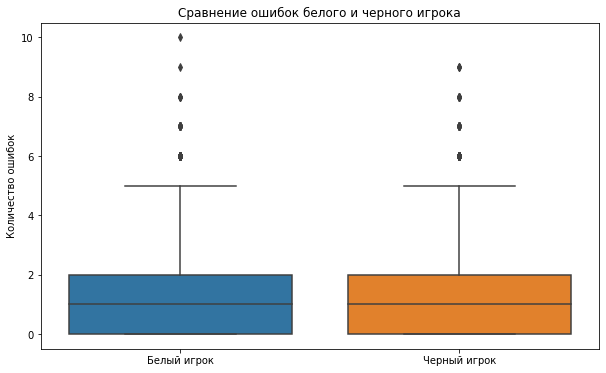

In [385]:
# 4.6. Коробчатая диаграмма для сравнения ошибок
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['White_Mistake', 'Black_Mistake']])
plt.title('Сравнение ошибок белого и черного игрока')
plt.ylabel('Количество ошибок')
plt.xticks([0, 1], ['Белый игрок', 'Черный игрок'])
plt.show()

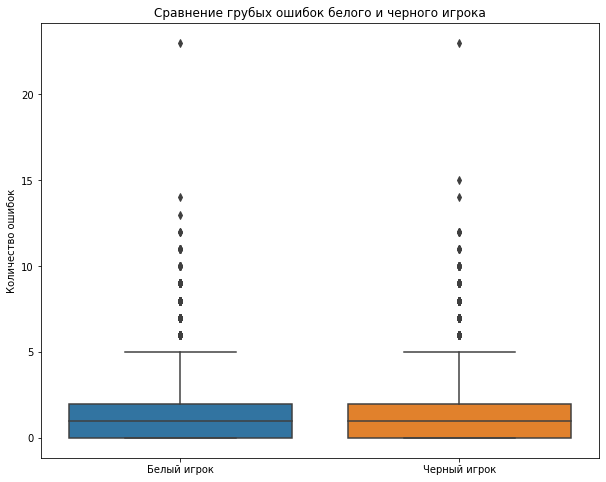

In [386]:
# 4.7. Коробчатая диаграмма для сравнения грубых ошибок
plt.figure(figsize=(10, 8))
sns.boxplot(data=df[['White_Blunder', 'Black_Blunder']])
plt.title('Сравнение грубых ошибок белого и черного игрока')
plt.ylabel('Количество ошибок')
plt.xticks([0, 1], ['Белый игрок', 'Черный игрок'])
plt.show()

Узнаем количество партий, сыгранных без ошибок для белых и черных игроков

In [387]:
# количество партий без ошибок для белых игроков.
no_errors_white = df.query("White_Mistake == 0 and White_Blunder == 0")

count_no_errors_white = no_errors_white.shape[0]

# количество партий без ошибок для черных игроков.
no_errors_black = df.query("Black_Mistake == 0 and Black_Blunder == 0")

count_no_errors_black = no_errors_black.shape[0]

print(f"Количество партий без ошибок у белых: {count_no_errors_white}")
print(f"Количество партий без ошибок у черных: {count_no_errors_black}")

Количество партий без ошибок у белых: 21352
Количество партий без ошибок у черных: 19398


Узнаем процент партий без ошибок у белых и черных в общем объеме

In [388]:
total_games = df.shape[0]

# Вычисление процента безошибочных партий у белых
percentage_no_errors_white = (count_no_errors_white / total_games) * 100

# Вычисление процента безошибочных партий у черных
percentage_no_errors_black = (count_no_errors_black / total_games) * 100

print(f"Процент партий без ошибок у белых: {percentage_no_errors_white:.2f}%")
print(f"Процент партий без ошибок у черных: {percentage_no_errors_black:.2f}%")

Процент партий без ошибок у белых: 18.11%
Процент партий без ошибок у черных: 16.46%


Узнаем были ли такие партиии, где ни белые, ни черные не совершили ни одной ошибки.

In [389]:
no_errors_white_and_black = df.query("White_Mistake == 0 and White_Blunder == 0 and Black_Mistake == 0 and Black_Blunder == 0")

count_no_errors_white_and_black = no_errors_white_and_black.shape[0]

# Вычисление процента безошибочных партий у белых и черных одновременно
percentage_no_errors_white_and_black = (count_no_errors_white_and_black / total_games) * 100

print(f"Количество партий, где ни белые, ни черные не совершили ни одной ошибки.: {count_no_errors_white_and_black}")
print(f"Процент партий, где ни белые, ни черные не совершили ни одной ошибки: {percentage_no_errors_white_and_black:.2f}%")

Количество партий, где ни белые, ни черные не совершили ни одной ошибки.: 4180
Процент партий, где ни белые, ни черные не совершили ни одной ошибки: 3.55%


Сложим ошибки и грубые ошибки всех игроков для одной партии и выведем их в новом столбце 'Total_Mistakes'

In [390]:
df['Total_Mistakes'] = df['White_Mistake'] + df['Black_Mistake'] + df['White_Blunder'] + df['Black_Blunder']

Исследуем медиану общего количества ошибок.

Вычислим медиану общего количества ошибок для каждого контроля времени партии (Speed)

In [391]:
median_errors_for_Speed = df.groupby('Speed')['Total_Mistakes'].median().reset_index(name='Median_Mistakes')

In [392]:
median_errors_for_Speed

,Speed,Median_Mistakes
0,blitz,4
1,bullet,5
2,classical,3
3,rapid,4
4,ultraBullet,7


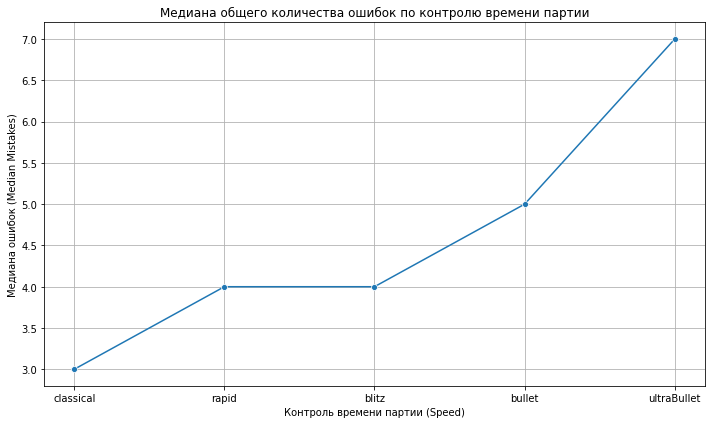

In [393]:
# Определяем порядок категорий
speed_order = ['classical', 'rapid', 'blitz', 'bullet', 'ultraBullet']

# Преобразуем столбец Speed в категориальный тип с заданным порядком
median_errors_for_Speed['Speed'] = pd.Categorical(median_errors_for_Speed['Speed'], categories=speed_order, ordered=True)

# Построение графика
plt.figure(figsize=(10, 6))
sns.lineplot(data=median_errors_for_Speed, x='Speed', y='Median_Mistakes', marker='o')

# Настройка графика
plt.title('Медиана общего количества ошибок по контролю времени партии')
plt.xlabel('Контроль времени партии (Speed)')
plt.ylabel('Медиана ошибок (Median Mistakes)')
plt.xticks(rotation=0)  # Устанавливаем угол поворота подписей на 0 градусов
plt.grid()

# Показать график
plt.tight_layout()
plt.show()

classical - от 60 минут до нескольких часов.

rapid - от 10 до 60 минут.

blitz - от 3-х до 10 минут.

bullet - менее 3-х минут.

ultraBullet - менее 1-ой минуты.

#### Параметр `White_ACPL`

White_ACPL - средний потерянный центильпешечный эквивалент (средняя ошибка по оценке движка) - числовой

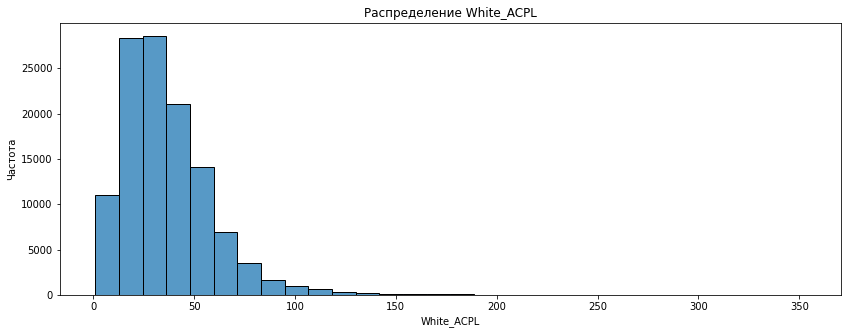

In [292]:
plt.figure(figsize=(14, 5))
sns.histplot(df['White_ACPL'], bins=30)
plt.title('Распределение White_ACPL')
plt.xlabel('White_ACPL')
plt.ylabel('Частота')
plt.show()

Распределение имеет положительную асимметрию (хвост уходит вправо), поэтому применим логарифмирование для уменьшения разброса значений и приведения данных к более нормальному виду.

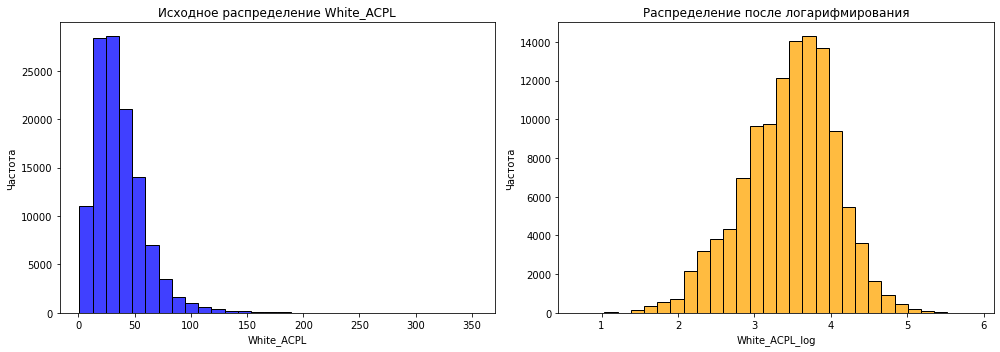

In [293]:
# Логарифмируем
df['White_ACPL_log'] = np.log1p(df['White_ACPL'])

# Строим график
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['White_ACPL'],
             bins=30, ax=ax[0], color="blue")
ax[0].set_title("Исходное распределение White_ACPL")
ax[0].set_xlabel("White_ACPL")
ax[0].set_ylabel("Частота")

sns.histplot(
    df['White_ACPL_log'], bins=30, ax=ax[1], color="orange")
ax[1].set_title("Распределение после логарифмирования")
ax[1].set_xlabel("White_ACPL_log")
ax[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

#### Параметр `Black_ACPL`

Black_ACPL - средний потерянный центильпешечный эквивалент (средняя ошибка по оценке движка) - числовой

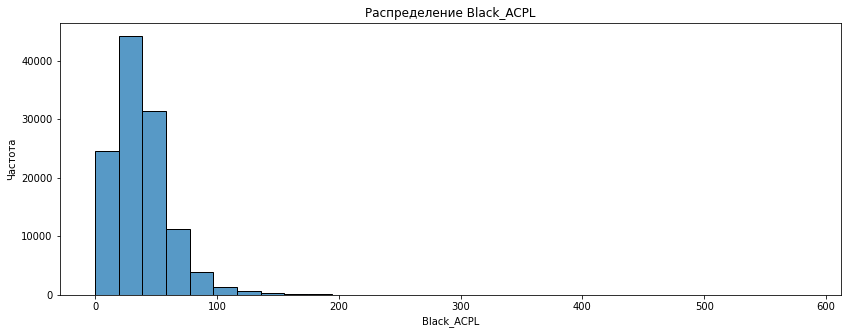

In [294]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Black_ACPL'], bins=30)
plt.title('Распределение Black_ACPL')
plt.xlabel('Black_ACPL')
plt.ylabel('Частота')
plt.show()

Повторим действия, как для White_ACPL

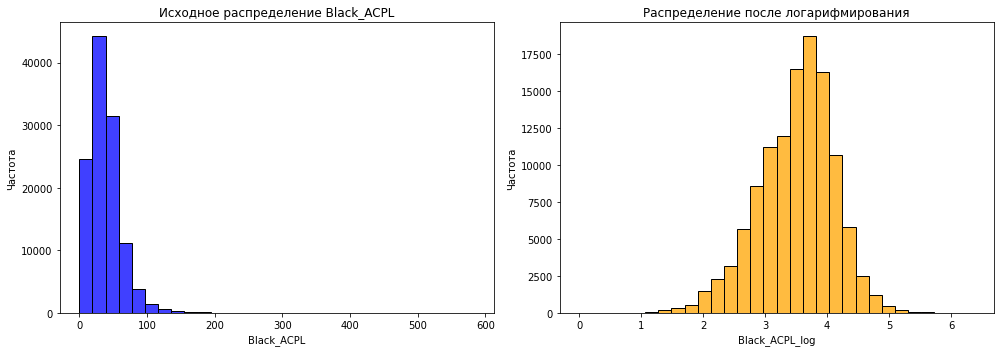

In [295]:
# Логарифмируем
df['Black_ACPL_log'] = np.log1p(df['Black_ACPL'])

# Строим график
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['Black_ACPL'],
             bins=30, ax=ax[0], color="blue")
ax[0].set_title("Исходное распределение Black_ACPL")
ax[0].set_xlabel("Black_ACPL")
ax[0].set_ylabel("Частота")

sns.histplot(
    df['Black_ACPL_log'], bins=30, ax=ax[1], color="orange")
ax[1].set_title("Распределение после логарифмирования")
ax[1].set_xlabel("Black_ACPL_log")
ax[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

#### Параметр `Clocks`

Clocks - информация о времени игроков по ходу партии в виде последовательного числового списка - категориальный

##### Новый параметр `White_Clocks` и `White_Clocks_Diffs`

Выделим отдельным параметром остаток времени на таймере игрока белыми фигруами после каждого хода

In [296]:
df['White_Clocks'] = df['Clocks'].apply(lambda x: x[::2])

Посчитаем затрачиваемое время на каждый ход игрока белыми фигурами

In [ ]:
def calculate_time_spent_with_increment(clock_list, increment):
    clocks_sec = [x / 100 for x in clock_list]
    spent = []
    for i in range(1, len(clocks_sec)):
        time_used = clocks_sec[i - 1] - clocks_sec[i] + increment
        spent.append(round(max(time_used, 0), 2))
    return spent


df['White_Clocks_Diffs'] = df.apply(lambda row: calculate_time_spent_with_increment(
    row['White_Clocks'], row['Total_Time_Increment']), axis=1)

In [ ]:
df['White_Clocks_Diffs']

##### Новый параметр `Black_Clocks` и `Black_Clocks_Diffs`

In [ ]:
df['Black_Clocks'] = df['Clocks'].apply(lambda x: x[1::2])

In [ ]:
df['Black_Clocks_Diffs'] = df.apply(lambda row: calculate_time_spent_with_increment(
    row['Black_Clocks'], row['Total_Time_Increment']), axis=1)

#### Параметр `Analysis`

Analysis - данные анализа партии от Lichess движка - категориальный

в этом столбце хранятся данные по оценке позиций на шахматной доске, которую дает шахматный движок.
Число этих оценок зависит от хода игры.

eval — это числовое значение, которое показывает, насколько хороша или плоха текущая позиция для одного из игроков. 

Положительное значение: позиция выгодна для белых.
Отрицательное значение: позиция выгодна для черных.
Ноль: позиция сбалансирована, ни одна сторона не имеет явного преимущества.

Найдем среднее значение eval для каждой партии 

In [396]:
# Проверка типа данных столбца Analysis
print(type(df['Analysis'].iloc[0]))

<class 'str'>


In [397]:
# Так как тип данных столбца Analysis строка, то необходимо преобразование строки в списки.
df['Analysis'] = df['Analysis'].apply(ast.literal_eval)

In [398]:
# Извлекаем значения eval из каждого словаря в списке с проверкой наличия ключа
def extract_eval(x):
    return [item['eval'] for item in x if 'eval' in item]

df['eval'] = df['Analysis'].apply(extract_eval)

# Найдем среднее значение eval для каждого элемента
df['avg_eval'] = df['eval'].apply(lambda x: sum(x) / len(x) if x else None)

In [399]:
avg_eval_column = df['avg_eval']
print(avg_eval_column)

0         186.257576
1         133.000000
2         -45.324324
3         110.714286
4         -21.457143
             ...    
117867    426.886792
117868   -342.734694
117869   -649.375000
117870    320.782609
117871    694.813953
Name: avg_eval, Length: 117872, dtype: float64


Найдем проценты партий, с приемущественными позициями белых и черных игроков.

In [400]:
# Общее количество партий
total_games = len(df)

# Подсчет партий в каждой категории
white_advantage = len(df[df['avg_eval'] > 0])
black_advantage = len(df[df['avg_eval'] < 0])
balanced_positions = len(df[df['avg_eval'] == 0])

# Вычисление процентов
white_advantage_percent = (white_advantage / total_games) * 100
black_advantage_percent = (black_advantage / total_games) * 100
balanced_positions_percent = (balanced_positions / total_games) * 100

# Вывод результатов
print(f"Процент партий, где преимущественно была выгодная позиция для белых: {white_advantage_percent:.2f}%")
print(f"Процент партий, где преимущественно была выгодная позиция для черных: {black_advantage_percent:.2f}%")
print(f"Процент сбалансированных позиций: {balanced_positions_percent:.2f}%")


Процент партий, где преимущественно была выгодная позиция для белых: 55.65%
Процент партий, где преимущественно была выгодная позиция для черных: 44.35%
Процент сбалансированных позиций: 0.00%


Найдем процент партий, где выиграли белые, несмотря на то, что средняя оценка позиции (avg_eval) была в пользу черных,
и наоборот, процент партий, где выиграли черные, несмотря на приемущество белых.

In [401]:
# Фильтрация партий, где белые выиграли, несмотря на преимущество черных
white_wins_black_advantage = df.query("Winner == 'white' and avg_eval < 0")

# Фильтрация партий, где черные выиграли, несмотря на преимущество белых
black_wins_white_advantage = df.query("Winner == 'black' and avg_eval > 0")

# Число партий, где игроку получилось резко развернуть ход игры в свою пользу, несмотря на приемущество противника в ходе игры.
result = pd.concat([white_wins_black_advantage, black_wins_white_advantage], ignore_index=True)

# Общее количество партий
total_games = len(df)

# Количество партий, соответствующих критериям
count_result = len(result)

percentage = count_result / total_games * 100

percentage = round(percentage, 0)

print("Общее количество партий:", total_games)
print("Количество партий, где белые выиграли с преимуществом черных или черные выиграли с преимуществом белых:", count_result)
print(f"Процент таких партий в общем объеме: {percentage:.2f} %")  # Используем f-строку для форматирования

Общее количество партий: 117872
Количество партий, где белые выиграли с преимуществом черных или черные выиграли с преимуществом белых: 13611
Процент таких партий в общем объеме: 12.00 %


Посчитаем количество оценок Lichess движка для каждой партии.

In [402]:
# Подсчет количества оценок в каждом списке
df['eval_count'] = df['eval'].apply(len)

# Группировка по Speed и вычисление среднего количества оценок
average_eval_count = df.groupby('Speed')['eval_count'].mean().reset_index(name='average_count')

# Выводим результат
print("\nСреднее количество оценок для каждой разновидности Speed:")
print(average_eval_count)


Среднее количество оценок для каждой разновидности Speed:
         Speed  average_count
0        blitz      82.374534
1       bullet      78.362331
2    classical      73.950163
3        rapid      79.511522
4  ultraBullet      60.508211


Сравним как распределяются значений eval в партиях с наибольшим и наименьшим числом ошибок.

In [403]:
distribution_eval = df[['Total_Mistakes','eval']]

In [404]:
distribution_eval = distribution_eval.sort_values("Total_Mistakes", ascending=False)

In [405]:
distribution_eval

,Total_Mistakes,eval
108586,55,"[14, 38, 11, 20, 5, 15, 8, 23, -8, -2, -12, -1..."
111951,37,"[0, 0, 0, 0, -12, 0, -25, -18, -19, -25, -34, ..."
54767,35,"[17, 24, -7, 0, -11, 0, 0, -6, 0, 0, 0, 0, 0, ..."
114237,33,"[17, 61, 0, 28, -94, 12, 13, 17, 4, 6, 0, 28, ..."
110498,31,"[12, 21, 8, 49, 50, 47, 39, 41, 51, 48, 34, 56..."
...,...,...
23738,0,"[18, 25, 13, 34, -9, -7, -23, -21, -24, -17, -..."
52914,0,"[15, 21, 11, 19, 19, 25, 14, 18, 21, 29, 31, 4..."
23739,0,"[18, 43, 43, 59, 67, 65, 70, 74, 78, 86, 89, 1..."
45573,0,"[15, 25, 22, 39, 20, 31, 15, 25, 43, 40, 19, 2..."


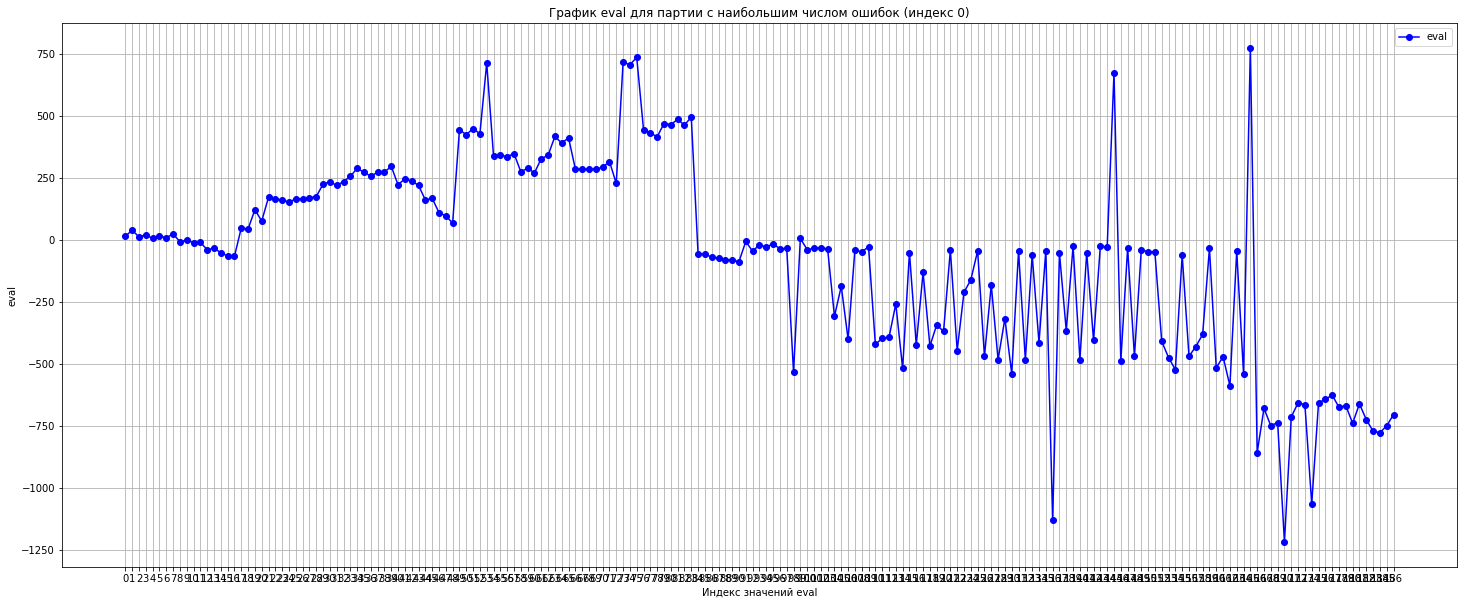

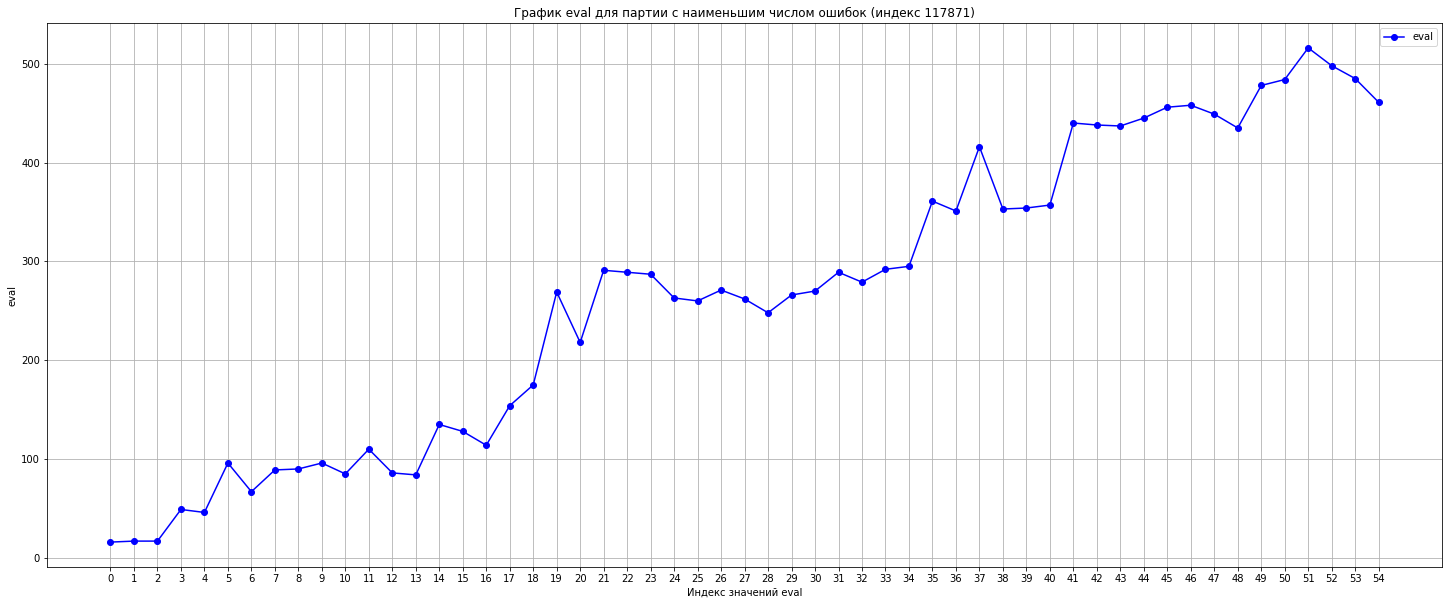

In [406]:
# Выбираем первую строку
row_index = 0  # Индекс первой строки
eval_values = distribution_eval['eval'].iloc[row_index]

# Создаем массив индексов для значений eval
index_values = list(range(len(eval_values)))

# Построение графика
plt.figure(figsize=(25, 10))
plt.plot(index_values, eval_values, marker='o', color='blue', label='eval')
plt.title(f'График eval для партии с наибольшим числом ошибок (индекс {row_index})')
plt.xlabel('Индекс значений eval')
plt.ylabel('eval')
plt.xticks(index_values)  # Устанавливаем метки по оси X
plt.grid()
plt.legend()
plt.show()


# Выбираем последнюю строку
row_index = len(distribution_eval) - 1  # Индекс последней строки
eval_values = distribution_eval['eval'].iloc[row_index]

# Создаем массив индексов для значений eval
index_values = list(range(len(eval_values)))

# Построение графика
plt.figure(figsize=(25, 10))
plt.plot(index_values, eval_values, marker='o', color='blue', label='eval')
plt.title(f'График eval для партии с наименьшим числом ошибок (индекс {row_index})')
plt.xlabel('Индекс значений eval')
plt.ylabel('eval')
plt.xticks(index_values)  # Устанавливаем метки по оси X
plt.grid()
plt.legend()
plt.show()

Вывод: Таким образом, мы прослеживаем закономерность между количеством ошибок и неоднородностью графика eval.
Чем больше ошибок, тем более неоднароден график eval, тем более резкие перепады между приемуществами белых и черных.

#### Параметр `Total_Time_Init`

Total_Time_Init - начальное время на партию в секундах - числовой

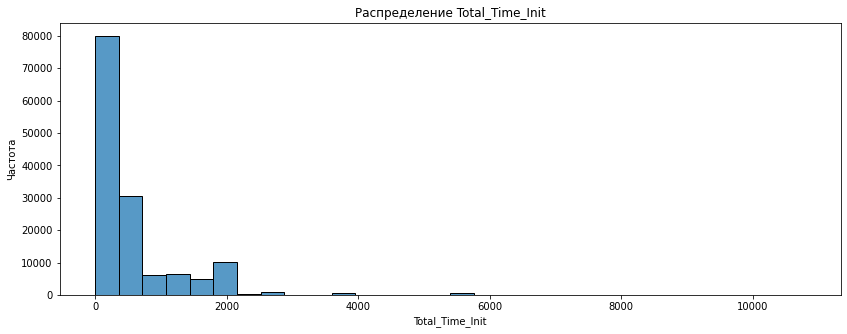

In [339]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Total_Time_Init'], bins=30)
plt.title('Распределение Total_Time_Init')
plt.xlabel('Total_Time_Init')
plt.ylabel('Частота')
plt.show()

Классические турниры по шахматам имеют стартовое время 60 минут и 90 минут в офлайне или менее. В онлайне партий с большим стартовым временем встречается очень мало, поэтому удалим все значения, что больше показателя в 2000 секунд и построим снова распределение

In [ ]:
df = df[df['Total_Time_Init'] <= 2000].reset_index(drop=True)

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Total_Time_Init',
             hue='Speed', multiple='stack', bins=30)
plt.title('Гистограмма Total_Time_Init по типу Speed')
plt.xlabel('Начальное время (секунды)')
plt.ylabel('Количество партий')
plt.grid(True)
plt.show()

Мы видим, что распределение практически совпадает с группами параметра `Speed`

#### Параметр `Total_Time_Increment`

Total_Time_Increment - добавление времени за ход в секундах - числовой

Посмотрим на распределение параметра

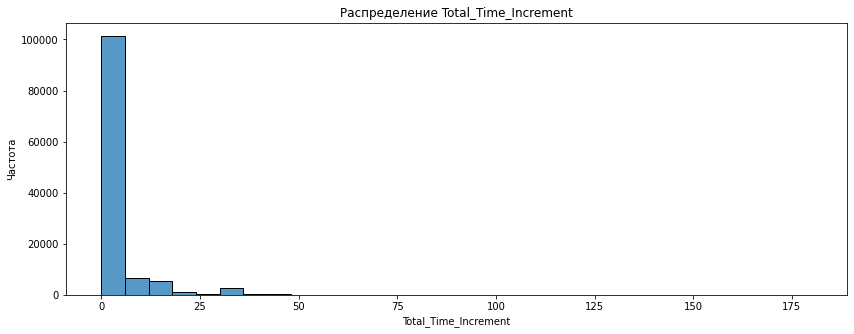

In [298]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Total_Time_Increment'], bins=30)
plt.title('Распределение Total_Time_Increment')
plt.xlabel('Total_Time_Increment')
plt.ylabel('Частота')
plt.show()

Видим что имеется большое кол-во выбросов. 
На практике классическим добавлением на ход по регламенту FIDE яв-ся 30 секунд. Что мы и видим на графике. 
Все, что больше 30 секунд добавления яв-ся нестандартной игрой. Поэтому удалим эти значения и затем построим новый график

In [299]:
df = df[df['Total_Time_Increment'] <= 31].reset_index(drop=True)

Посмотрим снова на распределение

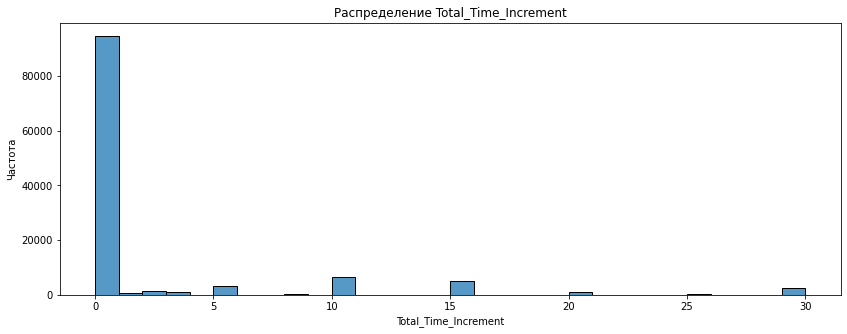

In [300]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Total_Time_Increment'], bins=30)
plt.title('Распределение Total_Time_Increment')
plt.xlabel('Total_Time_Increment')
plt.ylabel('Частота')
plt.show()

Создадим категориальный параметр для объединения распределений по группам

In [301]:
def group_increment(x):
    if x == 0:
        return '0 sec'
    elif x <= 3:
        return '1–3 sec'
    elif x <= 10:
        return '4–8 sec'
    elif x <= 15:
        return '9–15 sec'
    else:
        return '15+ sec'


df['Total_Time_Increment_Group'] = df['Total_Time_Increment'].apply(
    group_increment)

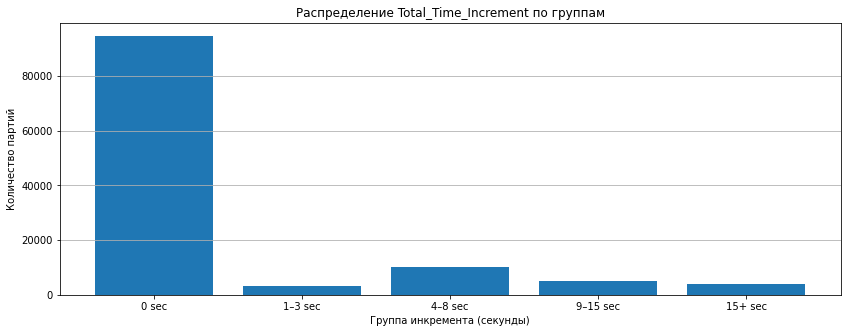

In [302]:
ordered_groups = ['0 sec', '1–3 sec', '4–8 sec', '9–15 sec', '15+ sec']

group_counts = df['Total_Time_Increment_Group'].value_counts().reindex(
    ordered_groups)

plt.figure(figsize=(14, 5))
plt.bar(group_counts.index, group_counts.values)
plt.title("Распределение Total_Time_Increment по группам")
plt.xlabel("Группа инкремента (секунды)")
plt.ylabel("Количество партий")
plt.grid(axis='y')
plt.show()

#### Параметр `Total_Time`

Total_Time - общее затраченное время на партию - числовой

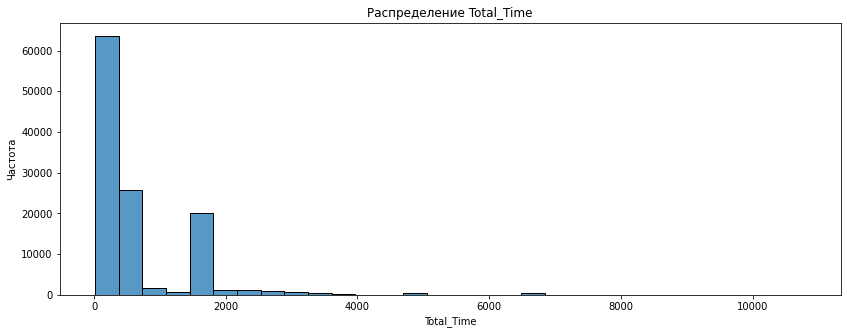

In [303]:
plt.figure(figsize=(14, 5))
sns.histplot(df['Total_Time'], bins=30)
plt.title('Распределение Total_Time')
plt.xlabel('Total_Time')
plt.ylabel('Частота')
plt.show()

In [304]:
# TODO: что делать с этим?
# Кажется, что этот столбец нужно дропнуть. Он не совпадает ни с Game_Duration, ни

In [305]:
# df[df['Total_Time_Increment'] > 0][['Num_Moves', 'Total_Time_Increment', 'Total_Time_Init', 'Total_Time', 'Game_Duration']]

Параметр `Moves`

Moves - список ходов, сделанных в партии - категориальный

Посмотрим какие самые популярные начальные ходы делаются в партиях.

In [ ]:
df["Moves"].apply(lambda x: x.split()[:6]).value_counts()

Посмотрим какой фигурой чаще всего делается последний ход

In [307]:
df["Moves"].apply(lambda x: "P" if x.split()[-1][0].islower() else x.split()
                           [-1][0] if x.split()[-1][0] != "O" else "Castle").value_counts()

Q         31511
R         27736
K         17217
P         15811
B         12546
N         12221
Castle      111
Name: Moves, dtype: int64

Чаще всего завершает игру ход Ферзем или ладьей

#### Новый параметр `is_Berserk`

Создадим параметр, показывающий брал ли игрок берсерк режим на партию

In [308]:
# TODO: реализовать

#### Новый параметр `Game_Duration`

Создадим на основе параметров `Created_At` и `Last_Move_At` параметр - продолжительность партии

In [ ]:
df['Game_Duration'] = (df['Last_Move_At'] - df['Created_At']).dt.total_seconds()

In [ ]:
plt.figure(figsize=(10, 4))
plt.hist(df['Game_Duration'], bins=50)
plt.title('Распределение длительности шахматных партий (в секундах)')
plt.xlabel('Длительность (секунды)')
plt.ylabel('Количество партий')
plt.grid(True)
plt.show()

In [ ]:
# TODO: Удаляем выбросы?
# TODO: Сравнить с Total_Time

#### Новый параметр `Num_Moves`

На основе параметра Moves - список ходов, сделанных в партии - категориальный.
Создадим новый параметр кол-во ходов в партии

In [ ]:
df["Num_Moves"] = df["Moves"].apply(
    lambda x: len(x.split()) // 2)

Посмотрим на распределение параметра и описательную статистику

In [ ]:
df["Num_Moves"].describe()

In [ ]:
plt.figure(figsize=(14, 5))
sns.histplot(df["Num_Moves"], bins=30)
plt.title("Распределение количества ходов в партиях")
plt.xlabel("Число ходов")
plt.ylabel("Частота")
plt.show()

## Корреляционная матрица

In [ ]:
correlation_matrix = df.select_dtypes(include=[np.number]).corr(method='spearman')

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f",
            cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляций числовых переменных")
plt.show()

In [ ]:
# TODO: Добавить категориальные признаки

In [ ]:
# TODO: Выводы по матрице